# CUS 5.13.0 User I/O Before and After Release Deployment

## Context

On May 26, 2020 version 5.13.0 of the CUS platform was released into production. This platform operates a 
datahub for real-time data of the public transport in Switzerland.
It serves the customer information by various channels, e.g. the information screens
at railway stations or bus stops. One of the core components of this platform is the CUS database, an 
Oracle 11.2 database appliance (ODA).

Daily monitoring of the User I/O related database wait events seems to imply that the database user I/O has 
increased considerably since. 

The analysis' objective is to prove or disapprove this conjecture.


## The Data

The data was taken was taken from the dynamic performance view *DBA_HIST_SYSSTAT*. It is described in Oracles 
reference documentation, found online at https://docs.oracle.com/cd/E11882_01/server.112/e40402/stats.htm#REFRN103.
This view contains hourly snapshots, i.e. it samples every hour the statistic values.

For the analysis I chose the statistics 
* physical read total IO requests, and
* physical read total bytes

The statistics values are accumulated, and taken at the end time of the snapshot. This usually is at the full hour.
Due to high system load, taking the snapshot might be delayed, or is skipped altogether.

**N.B. 1** When the database is restarted, the statistics are reset to 0. If this happens, a statistics increment between a snapshot and its successor will be negative.
**N.B. 2** Due to the circumstances mentioned above, the duration of a snapshot interval might vary considerable. This has to be taken into account for the analysis.


### Query

````sql
alter session set nls_timestamp_format = 'YYYY-MM-DD HH24:MI:SS';

select begin_interval_time, end_interval_time, snap_id, instance_number,
  stat_name, value
from dba_hist_sysstat@kihubprod_link.sbb.ch
natural join dba_hist_snapshot@kihubprod_link.sbb.ch
order by begin_interval_time, instance_number, stat_name;
````

### Datafile Structure

* File name: dba-hist-sysstat.dsv
* Format: Text file, CSV
* Character set encoding scheme: UTF-8
* Field separator: ";" (semicolon)
* First line: field names
* 2n line and below: records
* Field 1: BEGIN_INTERVAL_TIME; timestamp YYYY-MM-DD HH24:MI:SS
* Field 2: END_INTERVAL_TIME; timestamp YYYY-MM-DD HH24:MI:SS
* Field 3: SNAP_ID; snapshot ID, non-negative integer
* Field 4: INSTANCE_NUMBER; ID of the database instance, non-negative integer
* Field 5: STAT_NAME; statistics’ name
* Field 6: VALUE; statistics’ value, integer

### Load the data

In [26]:
import os
import numpy as np
import pandas as pd

os.chdir('../../data/Baseline.2020-06-11')
df = pd.read_csv('dba-hist-sysstat.dsv', sep=';', \
            names=['start', 'end', 'snapid', 'instance', 'stat', 'value'],
            header=1)
df.head(10)

,start,end,snapid,instance,stat,value
0,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,ADG parselock X get attempts,0
1,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,ADG parselock X get successes,0
2,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,application wait time,26423478
3,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,auto extends on undo tablespace,0
4,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,background checkpoints completed,3796
5,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,background checkpoints started,3796
6,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,background timeouts,116862829
7,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,Batched IO block miss count,2802075298
8,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,Batched IO (bound) vector count,31257017
9,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,Batched IO buffer defrag count,11558850


### Filtering and transforming the data; take only the 2 selected statistics

In [27]:
df = df[df.stat.isin(['physical read total IO requests', 'physical read total bytes'])]
df.start = pd.to_datetime(df.start, errors='raise')
df.end = pd.to_datetime(df.end, errors='raise')

## duration of a snapshot
snaplen = df.end - df.start
snaplen.name = 'snaplen'
df = pd.concat([df, snaplen], axis=1)

df.head(10)

,start,end,snapid,instance,stat,value,snaplen
422,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,physical read total bytes,161883305902592,01:00:11
424,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,physical read total IO requests,1636991568,01:00:11
1101,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,2,physical read total bytes,288673872805376,01:00:11
1103,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,2,physical read total IO requests,4822821721,01:00:11
1780,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,1,physical read total bytes,162020955790336,01:00:09
1782,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,1,physical read total IO requests,1638076663,01:00:09
2459,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,2,physical read total bytes,288761979712000,01:00:09
2461,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,2,physical read total IO requests,4823539809,01:00:09
3138,2020-05-13 02:00:34,2020-05-13 03:00:45,41929,1,physical read total bytes,162135784761856,01:00:11
3140,2020-05-13 02:00:34,2020-05-13 03:00:45,41929,1,physical read total IO requests,1638740086,01:00:11


In [28]:
df.describe()

,snapid,instance,value,snaplen
count,2868.000000,2868.000000,2.868000e+03,2868
mean,42294.960948,1.500000,1.275589e+14,0 days 00:59:59.818688
std,212.051270,0.500087,1.347797e+14,0 days 00:00:15.891085
min,41927.000000,1.000000,1.636992e+09,0 days 00:58:42
25%,42113.000000,1.000000,4.222492e+09,0 days 01:00:02
50%,42294.000000,1.500000,8.094451e+13,0 days 01:00:04
75%,42478.000000,2.000000,2.446867e+14,0 days 01:00:06
max,42662.000000,2.000000,3.380895e+14,0 days 01:01:30


### Preliminary conclusions

From the summary above one can see that the duration of a snapshot varys between 00:58:25 hours and 01:01:30 hours; there is no significant variation.

### Compute the increment between snapshots

In [29]:
df = df.sort_values(['snapid', 'instance', 'stat'], ascending=[1,1,1])
shiftval = df[['snapid', 'instance', 'stat', 'value']].groupby(['instance', 'stat'])['value'].shift(1)
shiftval.name = 'precvalue'  ## value of the precursor snapshot
df = pd.concat([df, shiftval], axis=1)

## drop rows having no precursor
df = df.dropna(axis=0)
df.head(10)

,start,end,snapid,instance,stat,value,snaplen,precvalue
1782,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,1,physical read total IO requests,1638076663,01:00:09,1.636992e+09
1780,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,1,physical read total bytes,162020955790336,01:00:09,1.618833e+14
2461,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,2,physical read total IO requests,4823539809,01:00:09,4.822822e+09
2459,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,2,physical read total bytes,288761979712000,01:00:09,2.886739e+14
3140,2020-05-13 02:00:34,2020-05-13 03:00:45,41929,1,physical read total IO requests,1638740086,01:00:11,1.638077e+09
3138,2020-05-13 02:00:34,2020-05-13 03:00:45,41929,1,physical read total bytes,162135784761856,01:00:11,1.620210e+14
3819,2020-05-13 02:00:34,2020-05-13 03:00:46,41929,2,physical read total IO requests,4826916072,01:00:12,4.823540e+09
3817,2020-05-13 02:00:34,2020-05-13 03:00:46,41929,2,physical read total bytes,288882333648896,01:00:12,2.887620e+14
4498,2020-05-13 03:00:45,2020-05-13 04:00:51,41930,1,physical read total IO requests,1641777405,01:00:06,1.638740e+09
4496,2020-05-13 03:00:45,2020-05-13 04:00:51,41930,1,physical read total bytes,162388210925056,01:00:06,1.621358e+14


In [33]:
df[df.value - df.precvalue < 0].count()

start        0
end          0
snapid       0
instance     0
stat         0
value        0
snaplen      0
precvalue    0
dtype: int64

No negative increments, therefore no database restart within the period under analysis.

### Split dataframe into df5121 (release 5.12.1) and df5130 (release 5.13.0)

In [31]:
df5121 = df[df.end < pd.to_datetime('2020-05-26 00:00:00', errors='raise')]
df5121.describe()

,snapid,instance,value,snaplen,precvalue
count,1208.000000,1208.000000,1.208000e+03,1208,1.208000e+03
mean,42083.589404,1.500000,1.192103e+14,0 days 00:59:59.723509,1.191680e+14
std,89.395708,0.500207,1.270914e+14,0 days 00:00:14.998416,1.270547e+14
min,41928.000000,1.000000,1.638077e+09,0 days 00:59:03,1.636992e+09
25%,42006.000000,1.000000,4.102934e+09,0 days 01:00:02,4.101285e+09
50%,42083.500000,1.500000,8.101310e+13,0 days 01:00:04,8.094428e+13
75%,42161.000000,2.000000,2.154520e+14,0 days 01:00:06,2.153450e+14
max,42237.000000,2.000000,3.106511e+14,0 days 01:00:26,3.106217e+14


In [32]:
df5130 = df[df.end >= pd.to_datetime('2020-05-26 04:00:00', errors='raise')]
df5130.describe()

,snapid,instance,value,snaplen,precvalue
count,1640.000000,1640.000000,1.640000e+03,1640,1.640000e+03
mean,42452.092683,1.500000,1.337645e+14,0 days 00:59:59.874390,1.337244e+14
std,121.554267,0.500153,1.399405e+14,0 days 00:00:16.562712,1.399049e+14
min,42242.000000,1.000000,1.949865e+09,0 days 00:58:42,1.945693e+09
25%,42347.000000,1.000000,4.550422e+09,0 days 01:00:02,4.547329e+09
50%,42452.500000,1.500000,9.576866e+13,0 days 01:00:04,9.567985e+13
75%,42557.000000,2.000000,2.502727e+14,0 days 01:00:06,2.501900e+14
max,42662.000000,2.000000,3.380895e+14,0 days 01:01:30,3.380434e+14


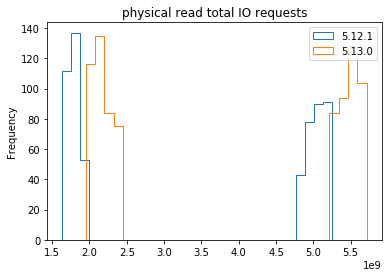

In [37]:
import matplotlib.pyplot as plt

plt.figure()
df5121[df5121.stat=='physical read total IO requests']['value'].plot(\
    kind="hist",bins=30,fill=False,histtype='step',label='5.12.1')
df5130[df5130.stat=='physical read total IO requests']['value'].plot(\
    kind="hist",bins=30,fill=False,histtype='step',label='5.13.0')
plt.title('physical read total IO requests')
plt.legend()
plt.show()

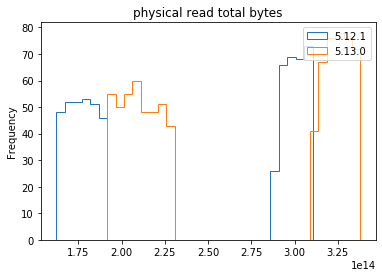

In [38]:
import matplotlib.pyplot as plt

plt.figure()
df5121[df5121.stat=='physical read total bytes']['value'].plot(\
    kind="hist",bins=30,fill=False,histtype='step',label='5.12.1')
df5130[df5130.stat=='physical read total bytes']['value'].plot(\
    kind="hist",bins=30,fill=False,histtype='step',label='5.13.0')
plt.title('physical read total bytes')
plt.legend()
plt.show()